# Reconstruction of the blurred images on the base of regularization in bounded Total Variation functional space. 

## Import necessary libraries

Note that here we import some functions from the file 'auxiliary'. These functions have been implemented earlier, during the reconstruction of blurred images via $H^1$ regularization. These functions are: 


* load_image(filename, N) - loads the image and changes its size to be $[N,N]$.
* kernel(image, kernel_radius) - creates the kernel: 

    \begin{equation*}
            k(x,y) = \begin{cases} 
                \frac{1}{\pi r^2}, & x^2 + y^2 \le r^2 \\ 
                0, & \text{elsewhere}
            \end{cases}
        \end{equation*}
        
     The size of the kernel is equal to the size of the image: $[N,N]$
* blurring(image, kernel) - convolves the image with a kernel in order to simulate the blurred image. 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from auxiliary import load_image, kernel
import scipy

In [2]:
def blurring(image, kernel):
    res = np.real(scipy.fft.fftshift(scipy.fft.ifftn(scipy.fft.fftn(image)*scipy.fft.fftn(kernel))))
    return res

## The residual functional 

Let $z(x,y)$ be an brightness distribution over the frame of the image to be processed, and let $u(x,y)$ to represent the blurred image. $(x,y) \in P = {x,y: |x|\le 1, |y|\le 1$. 

$$
    \Phi(z) = ||Az - u||_{L^2}^2, 
$$

where 

\begin{equation*}
   Az(x,y) = \iint\limits_{B} z(x,y) k(x-\xi,y-\eta) d\xi d\eta
\end{equation*}

With the uniform grid, the norm $L^2$ space norm is equal to a Frobenius norm. Implement the function allowing us to calculate the residual and its gradient. 

### Task: Implement the residual and its gradient

**Hint** The calculations are becoming much easier with usage of FFT. 
The gradient can be calculated using the following: 

$$
    \nabla\Phi = 2F^{-1}\Big[\hat{k}^*\big(\hat{k}\hat{z} - \hat{u}\big)\Big], 
$$

where $\cdot^*$ means the complex conjugation (np.conjugate)

The function should take the following arguments:
* $z$ - the image
* $p = [k, u, \alpha]$ - the set of parameters, including the right-hand side (the blurred image), the kernel, and the regularization parameter (by default, but see the hints below). 

The function should return both the value of the functional and its gradient. 


**Hint** In order to reduce the computational needs, it is better to pre-calculate all the things that can be precalculated once. For example, in the functional $\Phi$ only one thing is being changed from iteration to iteration: the solution $z(x,y)$. thus, the Fourier transforms of the kernel $k(x,y)$ and of the right-hand-side $u(x,y)$ can be pre-calculated and passed to the function Phi(z, \*p) as a part of \*p. In this case, $p = [\hat{k}, \hat{u}, \alpha]$

**Hint** Moreover, due to the Parseval's equality $||f||_{L^2} = ||\hat{f}||_{L^2}$. Try to understand how can you use it in order to reduce the computational needs while calculating the functional value and its gradient. 

In [3]:
def Phi(z, *p):
    K = p[0]
    K_conj = np.conjugate(K)
    U = p[1]
    
    N = U.shape[0]

    Z = scipy.fft.fftn(z)
    resid = K*Z - U
    phi = np.linalg.norm(resid)

    grad_Phi = 2*scipy.fft.ifftn(K_conj*resid)
    return phi, grad_Phi

## Test the $\Phi$ functional with zero array and with exact solution

Let $z_0(x,y)\equiv 0$, and $z^*$ be the exact solution (loaded sharp image). 

You must see the following: 
$$
    \Phi(z^*) \approx 0; \quad \Phi(z_0) >> 1
$$
$$ 
    ||\nabla\Phi(z^*)|| \approx 0; \quad ||\nabla\Phi(z_0)||>>1
$$

In [4]:
N = 1024
r = 0.1
z = load_image('test.png', N)

k = kernel(r, N)
K = scipy.fft.fftn(k)

u = blurring(z, k)
U = scipy.fft.fftn(u)

p = [K, U]

f, df = Phi(z, *p)
print('Phi(z_exact)='+str(f))
print('norm(grad_Phi(z_exact))='+str(np.linalg.norm(df)))

z0 = np.zeros(z.shape)
f, df = Phi(z0, *p)
print('Phi(z0)='+str(f))
print('norm(grad_Phi(z0))='+str(np.linalg.norm(df)))


N=1024
Phi(z_exact)=90916724.22353384
norm(grad_Phi(z_exact))=43304519.880533285
Phi(z0)=115663016.11198911
norm(grad_Phi(z0))=56897859.296153754


## The stabilizer functional and its gradient

The norm in Total Variation functional space is given in the simplest case by: 

$$
		\Omega(z) = ||z||_{VH} = \sup\limits_S \sum\limits_{i,j=0}^{N-2,M-2} |z_{i+1,j+1} - z_{ij+1}-z_{i+1j}+z_{ij}|,
$$ 

where the supremum is being taken within all possible meshes (including non-uniform) $S$.

The image, however, is defined on the uniform mesh; in terms of the uniform mesh, the norm above takes the following form: 

$$
    VH(z) = \sum\limits_{i,j=0}^{N-2,M-2} |z_{i+1,j+1} - z_{ij+1}-z_{i+1j}+z_{ij}|
$$

Note that the stabilizer above is not differentiable. In order to find the gradient, we can change it with such a differentiable approximation $\Omega_{\varepsilon} that (see \cite{1}, \cite{2}): 

$$
    0 \le \Omega_{\varepsilon}(z) - \Omega(z) \le \varepsilon\big(1+\varepsilon \Omega(z)\big)
$$

Such an approximation is, for example: 

$$
    \Omega(z) = \sum\limits_{i,j=0}^{N-2,M-2} f_{\varepsilon}(\hat{z}_{ij}), 
$$

where 

$$
    \hat{z}_{ij} = z_{i+1,j+1} - z_{ij+1}-z_{i+1j}+z_{ij}, 
$$

$$
    f_{\varepsilon}(\hat{z}_{ij}) = \sqrt{\hat{z}_{ij}^2 + \Big(\frac{\varepsilon}{N^2}\Big)^2}
$$

### The gradient of stabilizer

$$
    \nabla \Omega_{\varepsilon}(z)|_{ij} = \frac{\hat{z}_{ij}}{f_{\varepsilon}(\hat{z}_{ij})} +  
    \frac{\hat{z}_{i-1j-1}}{f_{\varepsilon}(\hat{z}_{i-1j-1})} - \frac{\hat{z}_{ij-1}}{f_{\varepsilon}(\hat{z}_{ij-1})} - \frac{\hat{z}_{i-1j}}{f_{\varepsilon}(\hat{z}_{i-1j})}
$$  


In [5]:
def fe(z, epsilon = 1e-4):
    return np.sqrt(z**2 + (epsilon/z.shape[0]**2)**2)

In [6]:
def Omega(z):
    z_ip1j = np.roll(z, -1, axis=0)
    z_ip1j[z_ip1j.shape[0]-1,:] = 0
    
    z_ijp1 = np.roll(z, -1, axis=1)
    z_ijp1[:,z_ijp1.shape[1]-1] = 0
    
    z_ip1jp1 = np.roll(z_ip1j, -1, axis=1)
    z_ip1jp1[:,z_ip1jp1.shape[1]-1] = 0
    
    hz = z_ip1jp1 - z_ip1j - z_ijp1 + z

    O = np.sum(fe(hz)) # The functional value

    hz_im1j = np.roll(hz, 1, axis=0)
    hz_im1j[0,:] = 0
    
    hz_ijm1 = np.roll(hz, 1, axis=1)
    hz_ijm1[:,0] = 0
    
    hz_im1jm1 = np.roll(hz_im1j, 1, axis=1)
    hz_im1jm1[:,0] = 0
    
    dO = hz/fe(hz) + hz_im1jm1/fe(hz_im1jm1) - hz_ijm1/fe(hz_ijm1) - hz_im1j/fe(hz_im1j) # The gradient
    return O, dO

## The Tikhonov's cost functional

$$
    M_{\alpha} = ||Az - u||_{L^2}^2 + \alpha ||z||_{VH}
$$

In [7]:
def cost_functional(z, *p):
    alpha = p[2]
    phi, grad_phi = Phi(z,*p)
    O, dO = Omega(z)
    M = phi + alpha*O
    dM = grad_phi + alpha*dO
    return M, dM

# The optimization

In order to minimize the cost functional, I propose to use the Conjugate Gradients algorithm. The algorithm has been impelemented by me, and I propose to use it (cgm_class2.py). However, you can use your own implementation or existing implementations (for example, some minimization algorithms are presented in the module 'scipy.optimize'). 

In [8]:
from cgm_class2 import *
def optimize(u, r, alpha, step, N_item):
    N = u.shape[0]

    k = kernel(r, N)

    K = scipy.fft.fftn(k)
    U = scipy.fft.fftn(u)

    z0 = np.zeros(u.shape)

    args = [K,U,alpha]
    
    opt = PCGMs(cost_functional, args)
    opt.set_step_interval(1e-10, 1e5)
    opt.step_mode = 'Constant'
    opt.print_freq(500)
    opt.set_csEPS(1e1)

    z_approx, cost = opt.minimize_cs(N_iter, z0, step)
    z_approx = np.real(scipy.fft.fftshift(z_approx))


    np.save('z_approx.npy', z_approx)
    coeff = 0.3

    return z_approx

## Test on simulated noiseless signal

N=256
N=256
Minimizer class initialized. Len(args[0]) = 3
CGM: Initial funcional value: 1854819.9331388301
CGM: Initial gradient norm: 931968.7943120186
CGM: iteration 500; step=0.0001; f=(327.8628916803689-1.59399834860302e-18j); Time elapsed: 2.8734607696533203
CGM: iteration 1000; step=0.0001; f=(129.71074420348384+7.182613457784756e-17j); Time elapsed: 2.7789509296417236
CGM BREAK: maximum number of iterations reached
Number of iterations: ............. 1001
Initial functional value: ......... 1854819.9331388301
Last Functional value: .............(129.54384626510281+7.165081479566356e-17j)
_________________________________________________


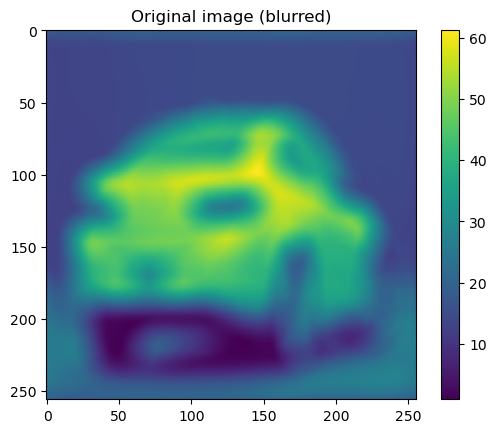

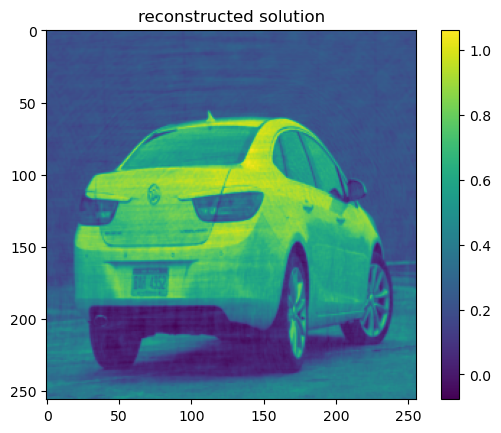

In [9]:
N = 256
r = 0.1

z = load_image('test.png', N)
k = kernel(r, N)

u = blurring(z, k)

alpha = 1e-4
step = 1e-4
N_iter = 1000


z_approx = optimize(u, r, alpha, step, N_iter)

plt.imshow(u)
plt.title('Original image (blurred)')
plt.colorbar()
plt.show()

plt.imshow(z_approx)
plt.colorbar()
plt.title('reconstructed solution')
plt.show()

## Test on simulated noisy signal

N=256
N=256
Minimizer class initialized. Len(args[0]) = 3
CGM: Initial funcional value: 1855123.6066586545
CGM: Initial gradient norm: 931905.7170722712
CGM: Reducing the step to be 0.0003333333333333333
CGM: Reducing the step to be 0.0001111111111111111
CGM: Reducing the step to be 3.7037037037037037e-05
CGM: Reducing the step to be 1.2345679012345678e-05
CGM: Reducing the step to be 4.115226337448559e-06
CGM: Reducing the step to be 1.371742112482853e-06
CGM: Reducing the step to be 4.5724737082761767e-07
CGM: Reducing the step to be 1.5241579027587256e-07
CGM: Reducing the step to be 5.0805263425290854e-08
CGM: Reducing the step to be 1.6935087808430285e-08
CGM: iteration 500; step=1.6935087808430285e-08; f=(39237.46057407021+3.6025436882253344e-06j); Time elapsed: 2.876041889190674
CGM: Reducing the step to be 5.645029269476761e-09
CGM: Reducing the step to be 1.8816764231589203e-09
CGM: Reducing the step to be 6.272254743863068e-10
CGM: iteration 1000; step=6.272254743863068e-10; 

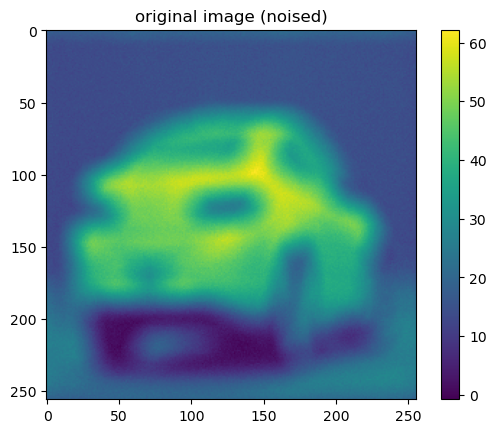

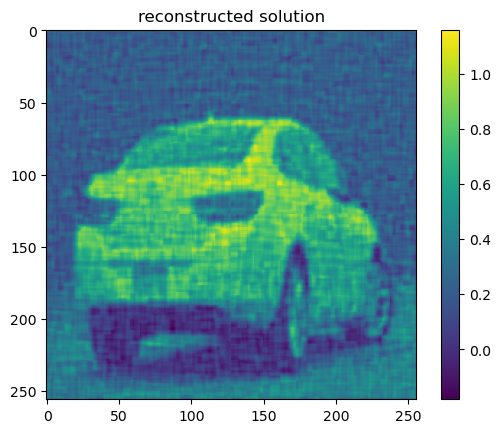

In [12]:
N = 256
r = 0.1
noise_level = 0.01
z = load_image('test.png', N)
k = kernel(r, N)

u = blurring(z, k)
u = u + noise_level*np.max(u)*np.random.randn(N,N)

alpha = 2e0
step = 1e-3
N_iter = 1000

z_approx = optimize(u, r, alpha, step, N_iter)

plt.imshow(u)
plt.colorbar()
plt.title('original image (noised)')
plt.show()

plt.imshow(z_approx)
plt.colorbar()
plt.title('reconstructed solution')
plt.show()

## Test with real photo

N=256
Minimizer class initialized. Len(args[0]) = 3
CGM: Initial funcional value: 58472.87230517253
CGM: Initial gradient norm: 28717.21951772223
CGM: Reducing the step to be 3.3333333333333337e-06
CGM: Reducing the step to be 1.1111111111111112e-06
CGM: Reducing the step to be 3.703703703703704e-07
CGM: iteration 500; step=3.703703703703704e-07; f=(673.1466020235218-0.0005608296688988543j); Time elapsed: 16.284438371658325
CGM: Reducing the step to be 1.234567901234568e-07
CGM: Reducing the step to be 4.11522633744856e-08
CGM: iteration 1000; step=4.11522633744856e-08; f=(633.4074354564117+0.0010766539466593888j); Time elapsed: 16.45953130722046
CGM BREAK: maximum number of iterations reached
Number of iterations: ............. 1001
Initial functional value: ......... 58472.87230517253
Last Functional value: .............(633.3400487912292+0.0009632705906291477j)
_________________________________________________


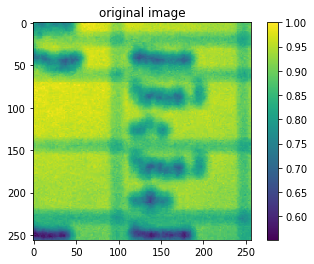

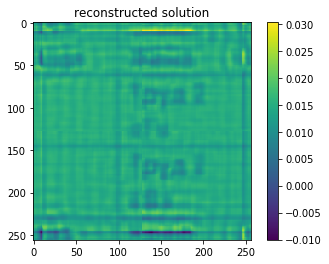

In [13]:
N = 256
r = 0.077 # Good for text image

u = load_image('test3.png', N)

alpha = 5e-1
step = 1e-5
N_iter = 1000

z_approx = optimize(u, r, alpha, step, N_iter)

plt.imshow(u)
plt.colorbar()
plt.title('original image')
plt.show()

plt.imshow(z_approx)
plt.colorbar()
plt.title('reconstructed solution')
plt.show()